In [1]:
from pathlib import Path
PROJECT_DIR = Path("/Users/bist/Downloads/NLP_BISTAS")
DATA_DIR = PROJECT_DIR / "data"
TWITTER_CSV = DATA_DIR / "twitter_training.csv"   

REPORTS = PROJECT_DIR / "reports"; FIGS = PROJECT_DIR / "figs"; MODELS = PROJECT_DIR / "models"; ART = PROJECT_DIR / "artifacts"; LOGS = PROJECT_DIR / "logs"
for d in [REPORTS, FIGS, MODELS, ART, LOGS]: d.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42



In [3]:
import os, re, json, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from datetime import datetime

import nltk, spacy
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_fscore_support,
                             accuracy_score, f1_score, make_scorer)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from imblearn.over_sampling import RandomOverSampler

print(">> Starting run at", datetime.now().isoformat())
print("PROJECT_DIR:", PROJECT_DIR)
print("TWITTER_CSV exists:", TWITTER_CSV.exists())


try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")


try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model: en_core_web_sm loaded")
except OSError:
    print("!! spaCy model 'en_core_web_sm' not found. Run:")
    print("   python -m spacy download en_core_web_sm")
    raise

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
sns.set(style="whitegrid")


>> Starting run at 2025-09-03T21:45:54.708496
PROJECT_DIR: /Users/bist/Downloads/NLP_BISTAS
TWITTER_CSV exists: True
spaCy model: en_core_web_sm loaded


In [5]:
def load_twitter(csv_path: Path) -> pd.DataFrame:
   
    try:
        tmp = pd.read_csv(csv_path, header=None)
        if tmp.shape[1] == 4:
            tmp.columns = ["tweet_id", "topic", "label", "text"]
            print(">> Loaded twitter with no header, 4 cols ->", tmp.shape)
            return tmp
    except Exception as e:
        print("Fallback to header read:", e)

    df = pd.read_csv(csv_path)
    if "text" not in df.columns:
        raise ValueError("Couldn't detect 'text' column. Inspect CSV.")
    print(">> Loaded twitter with header ->", df.shape, "cols:", df.columns.tolist())

    if "label" not in df.columns: raise ValueError("No 'label' column found.")
    if "tweet_id" not in df.columns and "id" in df.columns: df = df.rename(columns={"id":"tweet_id"})
    if "topic" not in df.columns: df["topic"] = ""
    return df

assert TWITTER_CSV.exists(), f"Missing file: {TWITTER_CSV}"
df = load_twitter(TWITTER_CSV)
df = df.dropna(subset=["text","label"]).reset_index(drop=True)
DOMAIN = "twitter"

print(df.head(3))
print("Unique labels:", df["label"].value_counts().to_dict())
print("Sample:", df.sample(3, random_state=RANDOM_SEED)[["text","label"]].to_dict(orient="records"))


>> Loaded twitter with no header, 4 cols -> (74682, 4)
   tweet_id        topic     label  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
Unique labels: {'Negative': 22358, 'Positive': 20655, 'Neutral': 18108, 'Irrelevant': 12875}
Sample: [{'text': 'Looks to me like he failed to check out the way of moving vehicle that clearly had the right of way. Guess by stupidity is on him...', 'label': 'Irrelevant'}, {'text': "Wow, it takes all sorts of crazy people out there, and her language proved she's not a lady.", 'label': 'Irrelevant'}, {'text': 'Nvidia Unveils The World’s Fastest Gaming Monitor - breakingnewspak.com/nvidia-unveils…  ', 'label': 'Neutral'}]


Label counts:
 label
Irrelevant    12875
Negative      22358
Neutral       18108
Positive      20655
Name: count, dtype: int64


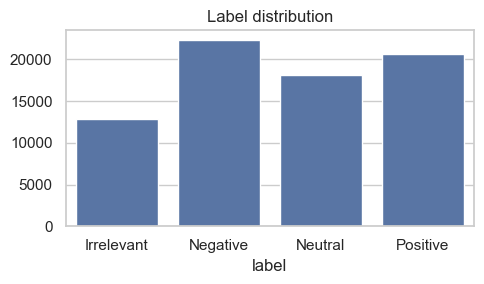

Saved: /Users/bist/Downloads/NLP_BISTAS/figs/twitter_label_distribution.png


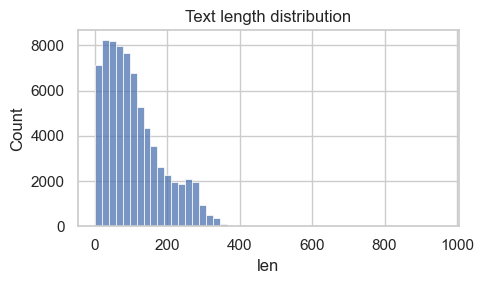

Saved: /Users/bist/Downloads/NLP_BISTAS/figs/twitter_length_hist.png
Top topics: {'MaddenNFL': 2377, 'LeagueOfLegends': 2377, 'CallOfDuty': 2376, 'Verizon': 2365, 'TomClancysRainbowSix': 2364, 'Facebook': 2362, 'Microsoft': 2361, 'Dota2': 2359, 'WorldOfCraft': 2357, 'ApexLegends': 2353}


In [7]:
FIGS.mkdir(parents=True, exist_ok=True)

label_counts = df["label"].value_counts().sort_index()
print("Label counts:\n", label_counts)

plt.figure(figsize=(5,3))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.title("Label distribution"); plt.tight_layout()
fig1 = FIGS / f"{DOMAIN}_label_distribution.png"
plt.savefig(fig1, dpi=150); plt.show()
print("Saved:", fig1)

df["len"] = df["text"].astype(str).str.len()
plt.figure(figsize=(5,3))
sns.histplot(df["len"], bins=50)
plt.title("Text length distribution"); plt.tight_layout()
fig2 = FIGS / f"{DOMAIN}_length_hist.png"
plt.savefig(fig2, dpi=150); plt.show()
print("Saved:", fig2)

if "topic" in df.columns and df["topic"].astype(str).str.len().gt(0).any():
    t_counts = df["topic"].astype(str).value_counts().head(10)
    print("Top topics:", t_counts.to_dict())


In [9]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

STOP = set(stopwords.words("english"))
URL_RE = re.compile(r"https?://\S+|www\.\S+")
USER_RE = re.compile(r"@\w+")
HASH_RE = re.compile(r"#\w+")
HTML_ENT_RE = re.compile(r"&[a-z]+;")
MULTI_SPACE_RE = re.compile(r"\s+")

def clean_basic(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.strip()
    s = URL_RE.sub(" ", s)
    s = USER_RE.sub(" @user ", s)
    s = HASH_RE.sub(" ", s)
    s = HTML_ENT_RE.sub(" ", s)
    s = MULTI_SPACE_RE.sub(" ", s)
    return s.strip()

def remove_stop(s: str) -> str:
    toks = word_tokenize(s)
    toks = [t for t in toks if t.lower() not in STOP]
    return " ".join(toks)

def lemmatize_spacy(s: str) -> str:
    doc = nlp(s)
    return " ".join([t.lemma_ for t in doc if not t.is_space])

def preprocess_text(s: str, do_stop=True, do_lemma=True):
    s = clean_basic(s)
    if do_stop: s = remove_stop(s)
    if do_lemma: s = lemmatize_spacy(s)
    return s

# Show effect on a few rows
ex = df.sample(5, random_state=RANDOM_SEED)["text"].tolist()
for i, t in enumerate(ex, 1):
    print(f"\n[{i}] RAW:   {t}")
    t1 = preprocess_text(t, do_stop=False, do_lemma=False)
    print(f"    clean: {t1}")
    t2 = preprocess_text(t, do_stop=True, do_lemma=True)
    print(f"    full:  {t2}")



[1] RAW:   Looks to me like he failed to check out the way of moving vehicle that clearly had the right of way. Guess by stupidity is on him...
    clean: Looks to me like he failed to check out the way of moving vehicle that clearly had the right of way. Guess by stupidity is on him...
    full:  look like fail check way move vehicle clearly right way . guess stupidity ...

[2] RAW:   Wow, it takes all sorts of crazy people out there, and her language proved she's not a lady.
    clean: Wow, it takes all sorts of crazy people out there, and her language proved she's not a lady.
    full:  wow , take sort crazy people , language prove 's lady .

[3] RAW:   Nvidia Unveils The World’s Fastest Gaming Monitor - breakingnewspak.com/nvidia-unveils…  
    clean: Nvidia Unveils The World’s Fastest Gaming Monitor - breakingnewspak.com/nvidia-unveils…
    full:  Nvidia Unveils World ' Fastest Gaming Monitor - breakingnewspak.com/nvidia-unveils …

[4] RAW:   Huge radio play here. Reinvention / C

In [11]:
ART.mkdir(parents=True, exist_ok=True)
df_proc = df.copy()
df_proc["text_clean"] = df_proc["text"].astype(str).map(lambda s: preprocess_text(s, True, True))
out_csv = ART / f"{DOMAIN}_processed.csv"
df_proc.to_csv(out_csv, index=False)
print(">> Cleaned data saved to:", out_csv)
df_proc[["text","text_clean","label"]].head(3)


>> Cleaned data saved to: /Users/bist/Downloads/NLP_BISTAS/artifacts/twitter_processed.csv


,text,text_clean,label
0,im getting on borderlands and i will murder yo...,"I m get borderland murder ,",Positive
1,I am coming to the borders and I will kill you...,"come border kill ,",Positive
2,im getting on borderlands and i will kill you ...,"I m get borderland kill ,",Positive


In [12]:
train_df, test_df = train_test_split(df_proc, test_size=0.15, random_state=RANDOM_SEED, stratify=df_proc["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.1765, random_state=RANDOM_SEED, stratify=train_df["label"])  # ≈15% of total

def dist(d): return d["label"].value_counts(normalize=True).round(3).to_dict()
print("Splits:", { "train":train_df.shape, "val":val_df.shape, "test":test_df.shape })
print("Label dist train/val/test:", dist(train_df), dist(val_df), dist(test_df))

for name, d in [("train",train_df),("val",val_df),("test",test_df)]:
    d.to_parquet(ART / f"{DOMAIN}_{name}.parquet", index=False)
print("Saved splits to", ART)


Splits: {'train': (51794, 6), 'val': (11102, 6), 'test': (11100, 6)}
Label dist train/val/test: {'Negative': 0.302, 'Positive': 0.279, 'Neutral': 0.245, 'Irrelevant': 0.174} {'Negative': 0.302, 'Positive': 0.279, 'Neutral': 0.245, 'Irrelevant': 0.174} {'Negative': 0.302, 'Positive': 0.279, 'Neutral': 0.245, 'Irrelevant': 0.174}
Saved splits to /Users/bist/Downloads/NLP_BISTAS/artifacts


In [13]:
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load

le = LabelEncoder()
y_train = le.fit_transform(train_df["label"])
y_val   = le.transform(val_df["label"])
y_test  = le.transform(test_df["label"])
classes = list(le.classes_)
print("Classes:", classes)

Xtr = train_df["text_clean"].values
Xva = val_df["text_clean"].values
Xte = test_df["text_clean"].values

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=60000, min_df=2)

models = {
    "LR":  LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM": LinearSVC(),
    "CNB": ComplementNB()
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
    print(f">> Training {name} ...")
    pipe.fit(Xtr, y_train)
    pred = pipe.predict(Xva)
    acc = accuracy_score(y_val, pred)
    p, r, f1, _ = precision_recall_fscore_support(y_val, pred, average="macro", zero_division=0)
    print(f"VAL {name}  acc={acc:.4f}  p={p:.4f}  r={r:.4f}  f1_macro={f1:.4f}")
    print(classification_report(y_val, pred, target_names=classes, digits=4))
    results[name] = {"val_acc": acc, "val_f1_macro": f1, "val_precision_macro": p, "val_recall_macro": r}
    dump(pipe, MODELS / f"{DOMAIN}_baseline_{name}.joblib")

print("Summary:", json.dumps(results, indent=2))
best_name = max(results, key=lambda k: results[k]["val_f1_macro"])
print(">> Best baseline on val:", best_name)


Classes: ['Irrelevant', 'Negative', 'Neutral', 'Positive']
>> Training LR ...
VAL LR  acc=0.8224  p=0.8182  r=0.8179  f1_macro=0.8179
              precision    recall  f1-score   support

  Irrelevant     0.7909    0.7790    0.7849      1932
    Negative     0.8549    0.8503    0.8526      3354
     Neutral     0.7916    0.8289    0.8098      2717
    Positive     0.8353    0.8135    0.8243      3099

    accuracy                         0.8224     11102
   macro avg     0.8182    0.8179    0.8179     11102
weighted avg     0.8228    0.8224    0.8224     11102

>> Training SVM ...
VAL SVM  acc=0.8904  p=0.8948  r=0.8823  f1_macro=0.8873
              precision    recall  f1-score   support

  Irrelevant     0.9137    0.8111    0.8593      1932
    Negative     0.9085    0.9120    0.9103      3354
     Neutral     0.9169    0.8848    0.9005      2717
    Positive     0.8402    0.9213    0.8789      3099

    accuracy                         0.8904     11102
   macro avg     0.8948    0

== TEST: SVM ==
              precision    recall  f1-score   support

  Irrelevant     0.9179    0.8400    0.8772      1931
    Negative     0.9091    0.9097    0.9094      3354
     Neutral     0.9146    0.8796    0.8968      2716
    Positive     0.8517    0.9248    0.8868      3099

    accuracy                         0.8944     11100
   macro avg     0.8983    0.8885    0.8925     11100
weighted avg     0.8960    0.8944    0.8944     11100



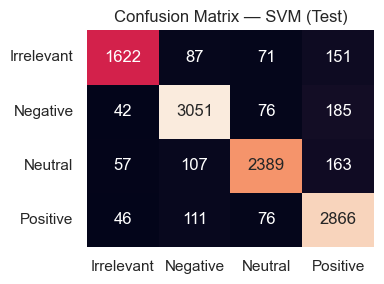

Saved: /Users/bist/Downloads/NLP_BISTAS/figs/twitter_cm_SVM_baseline_test.png


In [14]:
best_model = load(MODELS / f"{DOMAIN}_baseline_{best_name}.joblib")
test_pred = best_model.predict(Xte)
print(f"== TEST: {best_name} ==")
print(classification_report(y_test, test_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix — {best_name} (Test)")
plt.tight_layout()
fig_cm = FIGS / f"{DOMAIN}_cm_{best_name}_baseline_test.png"
plt.savefig(fig_cm, dpi=150); plt.show()
print("Saved:", fig_cm)


In [27]:
 
import os, json, numpy as np, torch, gc
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
import evaluate
from sklearn.preprocessing import LabelEncoder

print(">> Forcing CPU. CUDA available?", torch.cuda.is_available(), "| MPS available?", torch.backends.mps.is_available())


gc.collect()
if torch.backends.mps.is_available():
    try:
        torch.mps.empty_cache()
    except Exception:
        pass


cols_keep = ["text_clean","label"]
tr = train_df[cols_keep].rename(columns={"text_clean":"text"}).copy()
va = val_df[cols_keep].rename(columns={"text_clean":"text"}).copy()
te = test_df[cols_keep].rename(columns={"text_clean":"text"}).copy()


le_hf = LabelEncoder()
tr["labels"] = le_hf.fit_transform(tr["label"]).astype("int64")
va["labels"] = le_hf.transform(va["label"]).astype("int64")
te["labels"] = le_hf.transform(te["label"]).astype("int64")
num_labels = len(le_hf.classes_)
print("HF classes:", list(le_hf.classes_))


ds = DatasetDict({
    "train": Dataset.from_pandas(tr[["text","labels"]], preserve_index=False),
    "validation": Dataset.from_pandas(va[["text","labels"]], preserve_index=False),
    "test": Dataset.from_pandas(te[["text","labels"]], preserve_index=False),
})


model_name = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 128

def tok_fn(batch): 
    return tok(batch["text"], truncation=True, max_length=MAX_LEN)

ds_tok = ds.map(tok_fn, batched=True, remove_columns=["text"])
ds_tok = ds_tok.with_format("torch")
coll = DataCollatorWithPadding(tokenizer=tok)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.gradient_checkpointing_enable()
model.config.use_cache = False


acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


args = TrainingArguments(
    output_dir=str(MODELS / "hf_distilbert_cpu"),
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    num_train_epochs=3,
    per_device_train_batch_size=8,     
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",
    seed=RANDOM_SEED,
    fp16=False,
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    group_by_length=True,
    no_cuda=True,               
    use_mps_device=False,       
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    processing_class=tok,
    data_collator=coll,
    compute_metrics=compute_metrics
)

print(">> Training on CPU …")
trainer.train()
val_metrics  = trainer.evaluate(ds_tok["validation"])
test_metrics = trainer.evaluate(ds_tok["test"])
print("VAL:", val_metrics)
print("TEST:", test_metrics)

trainer.save_model(MODELS / "hf_distilbert_best_cpu")
json.dump({"val":val_metrics, "test":test_metrics}, open(ART / f"{DOMAIN}_distilbert_metrics_cpu.json","w"), indent=2)
print("Saved CPU model + metrics.")





>> Forcing CPU. CUDA available? False | MPS available? True
HF classes: ['Irrelevant', 'Negative', 'Neutral', 'Positive']


Map:   0%|          | 0/51794 [00:00<?, ? examples/s]

Map:   0%|          | 0/11102 [00:00<?, ? examples/s]

Map:   0%|          | 0/11100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1590: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


>> Training on CPU …


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.652000,0.698234,0.740317,0.727714
2,0.411300,0.499697,0.841200,0.836368
3,0.249200,0.556933,0.859034,0.855149


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


VAL: {'eval_loss': 0.5569329857826233, 'eval_accuracy': 0.8590344082147361, 'eval_f1_macro': 0.8551494337960801, 'eval_runtime': 47.6818, 'eval_samples_per_second': 232.835, 'eval_steps_per_second': 14.555, 'epoch': 3.0}
TEST: {'eval_loss': 0.5467833876609802, 'eval_accuracy': 0.8626126126126126, 'eval_f1_macro': 0.8590011435328392, 'eval_runtime': 50.3048, 'eval_samples_per_second': 220.655, 'eval_steps_per_second': 13.796, 'epoch': 3.0}
Saved CPU model + metrics.


BiLSTM classes: ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Shapes -> Xtr (51794, 60) Xva (11102, 60) Xte (11100, 60) | ytr (51794, 4) yva (11102, 4) yte (11100, 4)
!! glove.6B.100d.txt not found — proceeding with random embeddings (okay for baseline).


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 60, 100)        │     2,587,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,855,308 (10.89 MB)

 Trainable params: 267,908 (1.02 MB)

 Non-trainable params: 2,587,400 (9.87 MB)

>> Training BiLSTM …
Epoch 1/4
810/810 ━━━━━━━━━━━━━━━━━━━━ 67s 82ms/step - accuracy: 0.4159 - loss: 1.2701 - val_accuracy: 0.5515 - val_loss: 1.0710
Epoch 2/4
810/810 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - accuracy: 0.5730 - loss: 1.0330 - val_accuracy: 0.6377 - val_loss: 0.9023
Epoch 3/4
810/810 ━━━━━━━━━━━━━━━━━━━━ 69s 86ms/step - accuracy: 0.6550 - loss: 0.8617 - val_accuracy: 0.6795 - val_loss: 0.8028
Epoch 4/4
810/810 ━━━━━━━━━━━━━━━━━━━━ 68s 84ms/step - accuracy: 0.7242 - loss: 0.7052 - val_accuracy: 0.7152 - val_loss: 0.7381
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
== BiLSTM — TEST REPORT ==
              precision    recall  f1-score   support

  Irrelevant     0.6802    0.6168    0.6469      1931
    Negative     0.7773    0.7200    0.7476      3354
     Neutral     0.6742    0.7239    0.6982      2716
    Positive     0.7102    0.7622    0.7353      3099

    accuracy                         0.7148     11100
   macro avg     0.7105    0.7057    0.7070     11100
weighted avg    

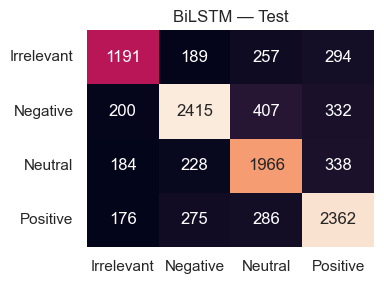

Saved: /Users/bist/Downloads/NLP_BISTAS/figs/twitter_cm_bilstm_test.png
Saved model to: /Users/bist/Downloads/NLP_BISTAS/models/keras_bilstm.h5


In [33]:

import numpy as np, pandas as pd, json, os
import tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt, seaborn as sns


if 'tr' not in globals() or 'va' not in globals() or 'te' not in globals():
    cols_keep = ["text_clean","label"]
    tr = train_df[cols_keep].rename(columns={"text_clean":"text"}).copy()
    va = val_df[cols_keep].rename(columns={"text_clean":"text"}).copy()
    te = test_df[cols_keep].rename(columns={"text_clean":"text"}).copy()
else:

    if 'text' not in tr.columns and 'text_clean' in tr.columns:
        tr = tr.rename(columns={"text_clean":"text"})
    if 'text' not in va.columns and 'text_clean' in va.columns:
        va = va.rename(columns={"text_clean":"text"})
    if 'text' not in te.columns and 'text_clean' in te.columns:
        te = te.rename(columns={"text_clean":"text"})


if 'labels' in tr.columns and 'labels' in va.columns and 'labels' in te.columns:
    # Use existing numeric labels
    y_tr_int = tr['labels'].astype('int64').to_numpy()
    y_va_int = va['labels'].astype('int64').to_numpy()
    y_te_int = te['labels'].astype('int64').to_numpy()
  
    if 'label' in tr.columns:
        le_lstm = LabelEncoder().fit(tr['label'])
        classes_lstm = list(le_lstm.classes_)
        num_labels = len(classes_lstm)
    else:
      
        num_labels = int(max(y_tr_int.max(), y_va_int.max(), y_te_int.max()) + 1)
        classes_lstm = [f"class_{i}" for i in range(num_labels)]
else:

    le_lstm = LabelEncoder()
    y_tr_int = le_lstm.fit_transform(tr['label'])
    y_va_int = le_lstm.transform(va['label'])
    y_te_int = le_lstm.transform(te['label'])
    classes_lstm = list(le_lstm.classes_)
    num_labels = len(classes_lstm)

print("BiLSTM classes:", classes_lstm)


MAX_VOCAB, MAX_LEN = 40000, 60
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(tr["text"])

Xtr = pad_sequences(tok.texts_to_sequences(tr["text"]), maxlen=MAX_LEN)
Xva = pad_sequences(tok.texts_to_sequences(va["text"]), maxlen=MAX_LEN)
Xte = pad_sequences(tok.texts_to_sequences(te["text"]), maxlen=MAX_LEN)

ytr = tf.keras.utils.to_categorical(y_tr_int, num_classes=num_labels)
yva = tf.keras.utils.to_categorical(y_va_int, num_classes=num_labels)
yte = tf.keras.utils.to_categorical(y_te_int, num_classes=num_labels)

print("Shapes -> Xtr", Xtr.shape, "Xva", Xva.shape, "Xte", Xte.shape, "| ytr", ytr.shape, "yva", yva.shape, "yte", yte.shape)


EMB_DIR = PROJECT_DIR / "embeddings"; EMB_DIR.mkdir(exist_ok=True)
GLOVE_TXT = EMB_DIR / "glove.6B.100d.txt"
emb_dim = 100
vocab_size = min(MAX_VOCAB, len(tok.word_index)+1)
emb_matrix = np.random.normal(scale=0.6, size=(vocab_size, emb_dim)).astype(np.float32)

if GLOVE_TXT.exists():
    print(">> Loading GloVe vectors…")
    glove = {}
    with open(GLOVE_TXT, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word, vec = parts[0], np.asarray(parts[1:], dtype="float32")
            glove[word] = vec
    for w, i in tok.word_index.items():
        if i < vocab_size and w in glove:
            emb_matrix[i] = glove[w]
else:
    print(f"!! {GLOVE_TXT.name} not found — proceeding with random embeddings (okay for baseline).")


inputs = layers.Input(shape=(MAX_LEN,), dtype="int32")
emb = layers.Embedding(vocab_size, emb_dim, weights=[emb_matrix], input_length=MAX_LEN, trainable=False)(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(emb)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_labels, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


print(">> Training BiLSTM …")
hist = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=4,
    batch_size=64,
    verbose=1
)

te_probs = model.predict(Xte, batch_size=256, verbose=1)
te_pred = te_probs.argmax(axis=1)

print("== BiLSTM — TEST REPORT ==")
print(classification_report(y_te_int, te_pred, target_names=classes_lstm, digits=4))

cm_lstm = confusion_matrix(y_te_int, te_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm_lstm, annot=True, fmt="d", cbar=False, xticklabels=classes_lstm, yticklabels=classes_lstm)
plt.title("BiLSTM — Test"); plt.tight_layout()
fig_lstm = FIGS / f"{DOMAIN}_cm_bilstm_test.png"
plt.savefig(fig_lstm, dpi=150); plt.show()
print("Saved:", fig_lstm)


SAVE_PATH = MODELS / "keras_bilstm.h5"
model.save(SAVE_PATH)
print("Saved model to:", SAVE_PATH)



In [34]:
SENTI_LEX = set("""
great good amazing excellent perfect love like awesome nice
bad terrible awful hate worse worst poor dull slow buggy noisy
""".split())

def aspects_rule(text: str):
    doc = nlp(text)
    chunks = []
    for ch in doc.noun_chunks:
        t = ch.text.strip()
        if 1 <= len(t.split()) <= 3:
            chunks.append(t)
    return list(dict.fromkeys(chunks))

def aspects_dep(text: str):
    doc = nlp(text)
    aspects = set()
    for tok in doc:
        if tok.dep_ == "amod" and tok.head.pos_ == "NOUN" and tok.lemma_.lower() in SENTI_LEX:
            aspects.add(tok.head.text)
        if tok.dep_ == "cop" and tok.head.pos_ == "ADJ":
            adj = tok.head
            for ch in adj.children:
                if ch.pos_ == "NOUN" and adj.lemma_.lower() in SENTI_LEX:
                    aspects.add(ch.text)
    return list(aspects)

probe = df_proc.sample(10, random_state=RANDOM_SEED).copy()
probe["aspects_rule"] = probe["text"].map(aspects_rule)
probe["aspects_dep"]  = probe["text"].map(aspects_dep)
print(probe[["text","aspects_rule","aspects_dep"]].to_string(index=False, max_colwidth=80))


                                                                            text                                                            aspects_rule aspects_dep
Looks to me like he failed to check out the way of moving vehicle that clearl... [me, he, the way, moving vehicle, that, the right, way, stupidity, him]          []
Wow, it takes all sorts of crazy people out there, and her language proved sh...                [it, all sorts, crazy people, her language, she, a lady]          []
Nvidia Unveils The World’s Fastest Gaming Monitor - breakingnewspak.com/nvidi...                                                        [Nvidia Unveils]          []
Huge radio play here. Reinvention / Corporate Evolution History of Microsoft ...                       [Huge radio play, Microsoft Microsoft, bloomberg]          []
                                                      SO I HAPPY WHO ABOUT THIS.                                                          [I, WHO, THIS]          []
          

In [35]:

WINDOW = 8 

def aspect_sentiment(record_text: str, aspects: list[str]):
    tokens = record_text.split()
    outs = []
    for a in aspects:
  
        try:
            idx = tokens.index(a.split()[0])  
        except ValueError:
            continue
        lo = max(0, idx - WINDOW); hi = min(len(tokens), idx + WINDOW + 1)
        window_text = " ".join(tokens[lo:hi])
        pred = best_model.predict([window_text])[0]
        outs.append({"aspect": a, "sentiment": le.inverse_transform([pred])[0], "span": [lo, hi]})
    return outs

sample = df_proc.sample(15, random_state=RANDOM_SEED).copy()
sample["aspects"] = sample["text"].map(aspects_rule)
sample["aspect_sentiments"] = sample.apply(lambda r: aspect_sentiment(r["text"], r["aspects"]), axis=1)
for _, row in sample.iterrows():
    print("\nTEXT:", row["text"])
    print("ASPECTS+SENT:", row["aspect_sentiments"])



TEXT: Looks to me like he failed to check out the way of moving vehicle that clearly had the right of way. Guess by stupidity is on him...
ASPECTS+SENT: [{'aspect': 'me', 'sentiment': 'Neutral', 'span': [0, 11]}, {'aspect': 'he', 'sentiment': 'Neutral', 'span': [0, 13]}, {'aspect': 'the way', 'sentiment': 'Neutral', 'span': [1, 18]}, {'aspect': 'moving vehicle', 'sentiment': 'Neutral', 'span': [4, 21]}, {'aspect': 'that', 'sentiment': 'Neutral', 'span': [6, 23]}, {'aspect': 'the right', 'sentiment': 'Neutral', 'span': [1, 18]}, {'aspect': 'way', 'sentiment': 'Neutral', 'span': [2, 19]}, {'aspect': 'stupidity', 'sentiment': 'Neutral', 'span': [15, 27]}]

TEXT: Wow, it takes all sorts of crazy people out there, and her language proved she's not a lady.
ASPECTS+SENT: [{'aspect': 'it', 'sentiment': 'Negative', 'span': [0, 10]}, {'aspect': 'all sorts', 'sentiment': 'Negative', 'span': [0, 12]}, {'aspect': 'crazy people', 'sentiment': 'Negative', 'span': [0, 15]}, {'aspect': 'her language',

In [36]:
scorer = {"f1_macro": make_scorer(f1_score, average="macro"), "accuracy":"accuracy"}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def cv_report(clf):
    pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])
    f1s = cross_val_score(pipe, df_proc["text_clean"], le.fit_transform(df_proc["label"]), cv=cv, scoring=scorer["f1_macro"])
    accs = cross_val_score(pipe, df_proc["text_clean"], le.fit_transform(df_proc["label"]), cv=cv, scoring=scorer["accuracy"])
    return {"f1_macro_mean": f1s.mean(), "f1_macro_std": f1s.std(), "acc_mean": accs.mean(), "acc_std": accs.std()}

cv_results = {
    "LR":  cv_report(LogisticRegression(max_iter=2000, class_weight="balanced")),
    "SVM": cv_report(LinearSVC()),
    "CNB": cv_report(ComplementNB())
}
print(json.dumps(cv_results, indent=2))
json.dump(cv_results, open(ART / f"{DOMAIN}_cv_baselines.json","w"), indent=2)


{
  "LR": {
    "f1_macro_mean": 0.8235673989631156,
    "f1_macro_std": 0.0007096606873447079,
    "acc_mean": 0.8263149482342671,
    "acc_std": 0.0009924022769746558
  },
  "SVM": {
    "f1_macro_mean": 0.8935524680671104,
    "f1_macro_std": 0.001997883289650054,
    "acc_mean": 0.8951159912192752,
    "acc_std": 0.0019125621552874904
  },
  "CNB": {
    "f1_macro_mean": 0.8060254465279348,
    "f1_macro_std": 0.003895467944761271,
    "acc_mean": 0.8139224226253416,
    "acc_std": 0.003970649028496355
  }
}


In [37]:
def train_eval_variant(do_stop, do_lemma):
    Xtr2 = train_df["text"].map(lambda s: preprocess_text(s, do_stop, do_lemma)).values
    Xva2 = val_df["text"].map(lambda s: preprocess_text(s, do_stop, do_lemma)).values
    pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), max_features=60000, min_df=2)),
                     ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
    pipe.fit(Xtr2, y_train)
    pred = pipe.predict(Xva2)
    return precision_recall_fscore_support(y_val, pred, average="macro", zero_division=0)[2]

abl = {
    "clean_only": train_eval_variant(False, False),
    "clean+stop": train_eval_variant(True,  False),
    "clean+lemma": train_eval_variant(False, True),
    "clean+stop+lemma": train_eval_variant(True, True),
}
print("Ablation macro-F1:", abl)
json.dump(abl, open(ART / f"{DOMAIN}_ablation.json","w"), indent=2)


Ablation macro-F1: {'clean_only': 0.8221659555365166, 'clean+stop': 0.8162229019417648, 'clean+lemma': 0.8137429231266589, 'clean+stop+lemma': 0.8178832245224598}


== Baseline TEST report ==
              precision    recall  f1-score   support

  Irrelevant     0.9179    0.8400    0.8772      1931
    Negative     0.9091    0.9097    0.9094      3354
     Neutral     0.9146    0.8796    0.8968      2716
    Positive     0.8517    0.9248    0.8868      3099

    accuracy                         0.8944     11100
   macro avg     0.8983    0.8885    0.8925     11100
weighted avg     0.8960    0.8944    0.8944     11100



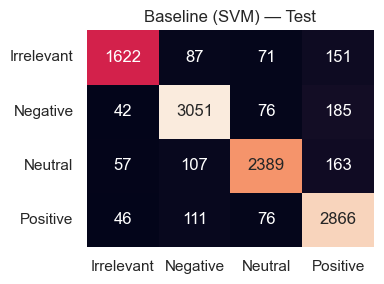

Saved: /Users/bist/Downloads/NLP_BISTAS/figs/twitter_cm_SVM_baseline_test.png
Exported sample baseline errors to: /Users/bist/Downloads/NLP_BISTAS/reports/twitter_baseline_errors.csv


In [40]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt


if 'le' not in globals():
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["label"])
    y_val   = le.transform(val_df["label"])
    y_test  = le.transform(test_df["label"])
    classes = list(le.classes_)

from joblib import load
if 'best_model' not in globals():
 
    best_model = load(MODELS / f"{DOMAIN}_baseline_{best_name}.joblib")


Xtr_base = train_df["text_clean"].astype(str).tolist()
Xva_base = val_df["text_clean"].astype(str).tolist()
Xte_base = test_df["text_clean"].astype(str).tolist()


y_pred_base = best_model.predict(Xte_base)


test_df_eval = test_df.copy()
test_df_eval["y_true"] = y_test
test_df_eval["y_pred_base"] = y_pred_base
test_df_eval["true_label"] = [classes[i] for i in test_df_eval["y_true"]]
test_df_eval["pred_label"] = [classes[i] for i in test_df_eval["y_pred_base"]]

print("== Baseline TEST report ==")
print(classification_report(test_df_eval["y_true"], test_df_eval["y_pred_base"], target_names=classes, digits=4))

cm = confusion_matrix(test_df_eval["y_true"], test_df_eval["y_pred_base"])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=classes, yticklabels=classes)
plt.title(f"Baseline ({best_name}) — Test")
plt.tight_layout()
fig_path = FIGS / f"{DOMAIN}_cm_{best_name}_baseline_test.png"
plt.savefig(fig_path, dpi=150); plt.show()
print("Saved:", fig_path)


errors_base = test_df_eval[test_df_eval["true_label"] != test_df_eval["pred_label"]]
err_csv = REPORTS / f"{DOMAIN}_baseline_errors.csv"
errors_base[["text","true_label","pred_label"]].head(200).to_csv(err_csv, index=False)
print("Exported sample baseline errors to:", err_csv)

